In [437]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("muted", color_codes=True)

def regress(keys):
    """Simple regression function, wrapping the statsmodels OLS API"""
    X = df[keys]
    y = df['mpg']
    X = sm.add_constant(X)

    est = sm.OLS(y, X).fit()
    return est.summary()

# Clean and load data

1. Remove any rows with **missing** or **malformed** data
2. Remove duplicates, checking tuples `(name, model-year, trans)`

In [410]:
df = pd.read_csv('mpg.csv')

# Create categorical variables for weight range and year range
df['weight-range_ord'] = pd.Categorical(df['weight-range']).codes
df['year-range_ord'] = pd.Categorical(df['year-range']).codes

df.head()

,weight-range,year-range,name,model-year,mpg,weight,percent-weight-front,length,width,height,cylinders,eng-displacement,trans,trans-speed,weight-range_ord,year-range_ord
0,1500-2000,1988-1992,Chevrolet Sprint,1988,47.0,1562.0,59.0,144.49,60.24,53.15,3,1.0,0,5,0,0
1,2000-2500,1988-1992,Chevrolet Sprint,1989,39.0,1562.0,59.0,144.49,60.24,53.15,3,1.0,0,5,1,0
2,1500-2000,1993-1997,Suzuki Swift,1993,40.0,1648.0,60.0,147.64,62.20,53.15,3,1.0,0,5,0,1
3,1500-2000,2009-2015,Smart Fortwo Brabus,2012,35.0,1653.0,43.0,106.30,61.42,60.63,3,1.0,0,5,0,4
4,2000-2500,1988-1992,Suzuki Swift,1989,40.0,1661.0,59.0,146.06,62.20,53.15,3,1.0,0,5,1,0


# Plot regressions for individual predictors

Quick observations: 

- `weight` and `width` appear to correlate approximately linearly, and follow one another
- `model-year` appears uniform
- `height` appears linearly-separable, with a gap around the 62-inch mark
- `percent-weight-front` appears heavily left-skewed
- `cylinders` appears to correlate linearly
- `eng-displacement` appears right-skewed
- `trans` and `trans-speed` appear uniform

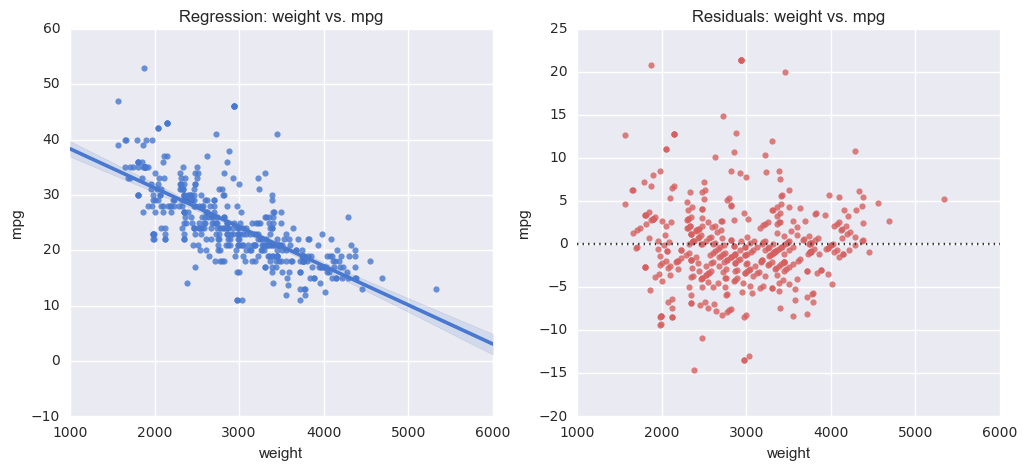

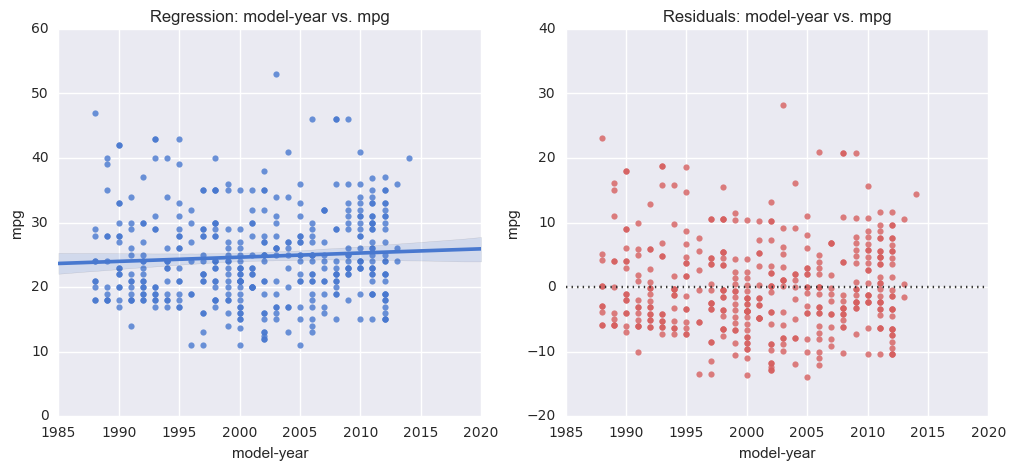

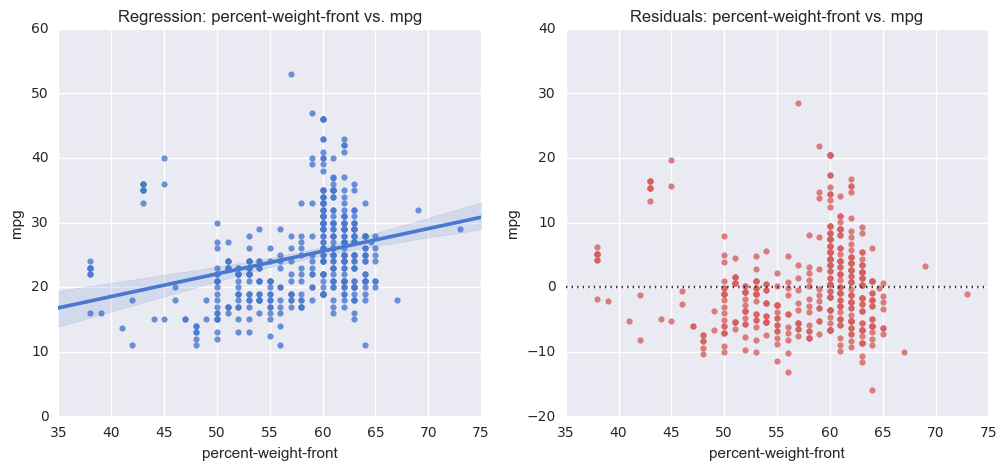

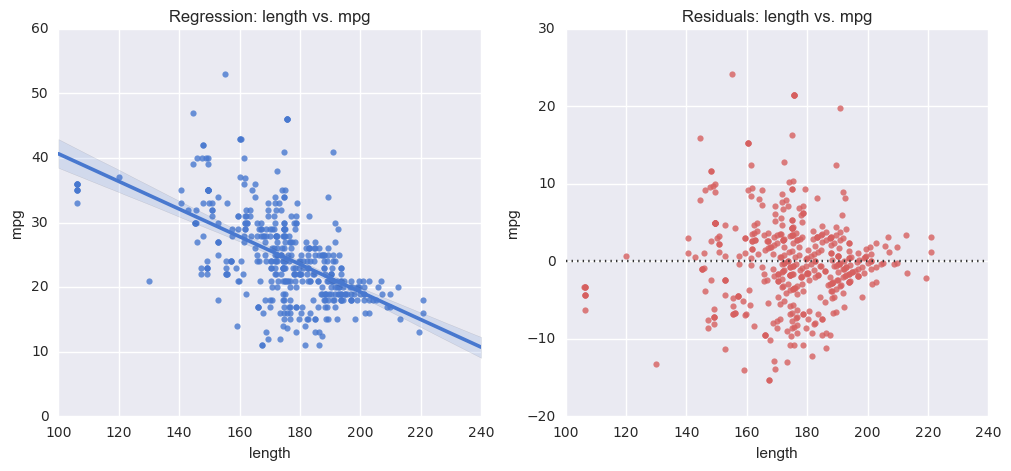

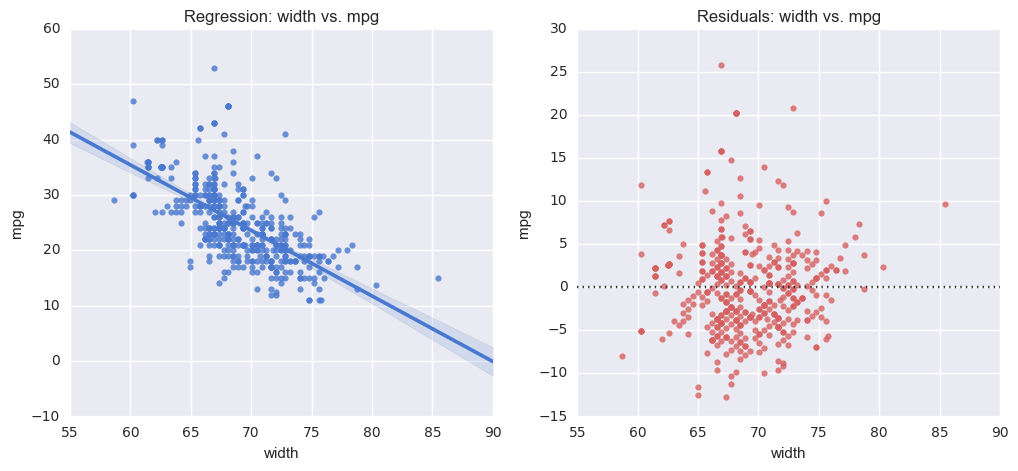

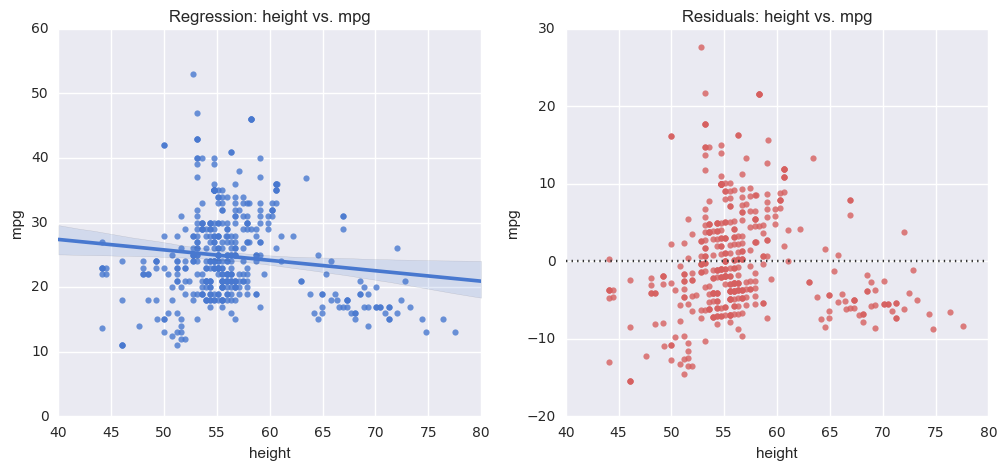

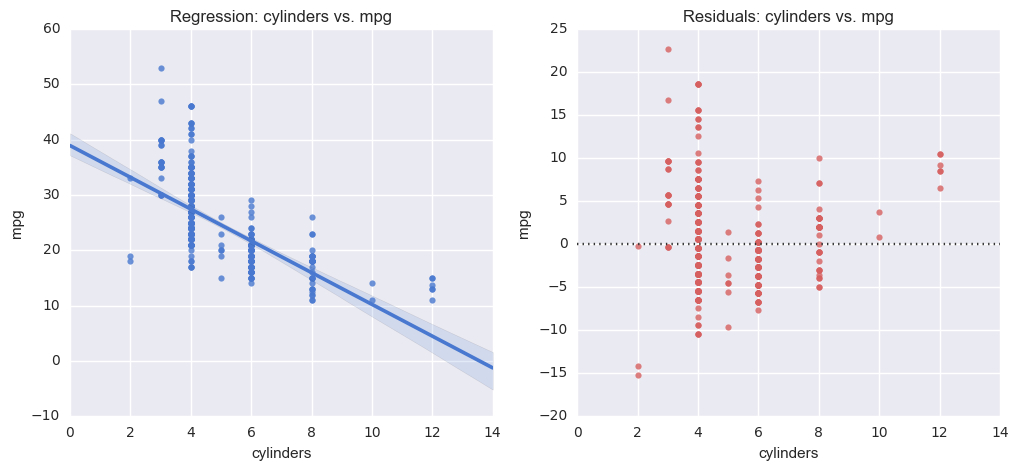

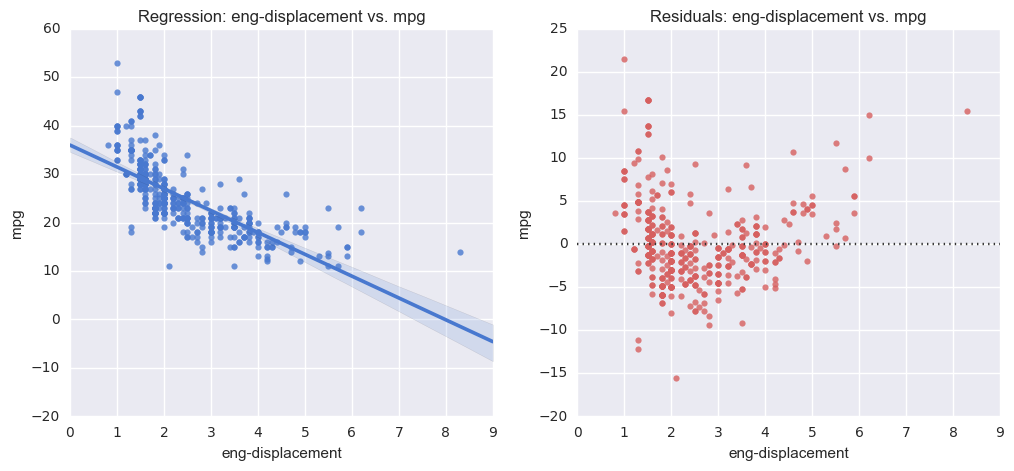

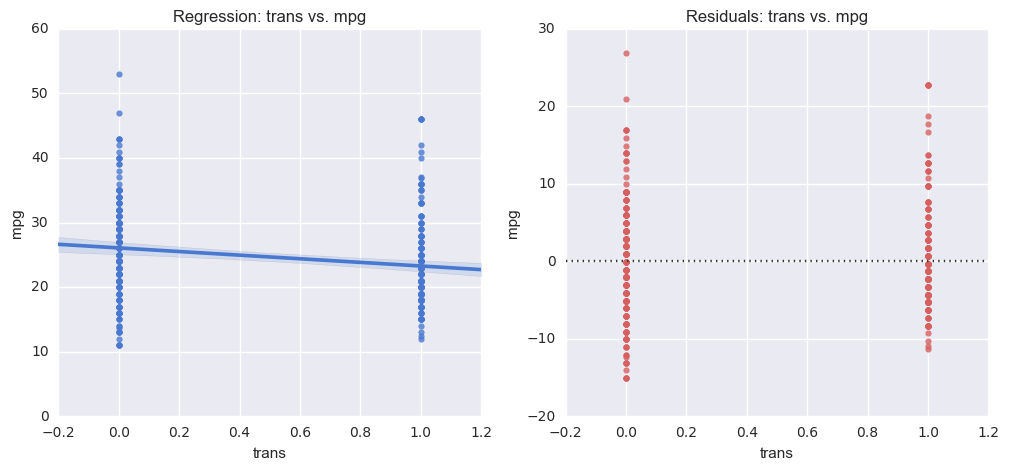

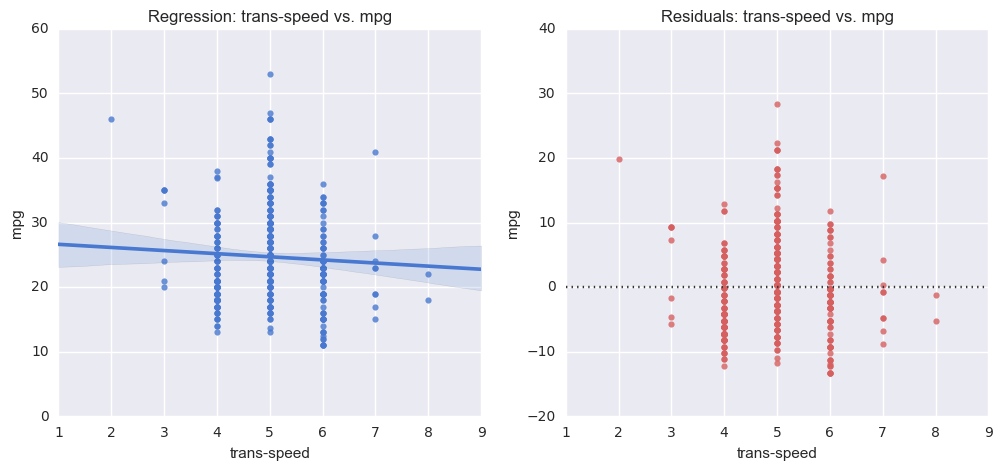

In [239]:
def plot_regression(k, order=1):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Regression: {} vs. mpg'.format(k))
    sns.regplot(x=k, y='mpg', data=df, color='b', order=order)
    plt.subplot(1, 2, 2)
    plt.title('Residuals: {} vs. mpg'.format(k))
    sns.residplot(x=k, y='mpg', data=df, color='r', order=order)
    plt.show()
    
keys = ['weight', 'model-year', 'percent-weight-front', 'length',
       'width', 'height', 'cylinders', 'eng-displacement', 'trans', 'trans-speed']

for k in keys:
    plot_regression(k)

## Transforming `eng-displacement`

We tested three transformations:

- Logarithmic
- Reciprocal
- Second-order polynomial

The reciprocal transformation performed the best when added as a predictor alongside `weight`.

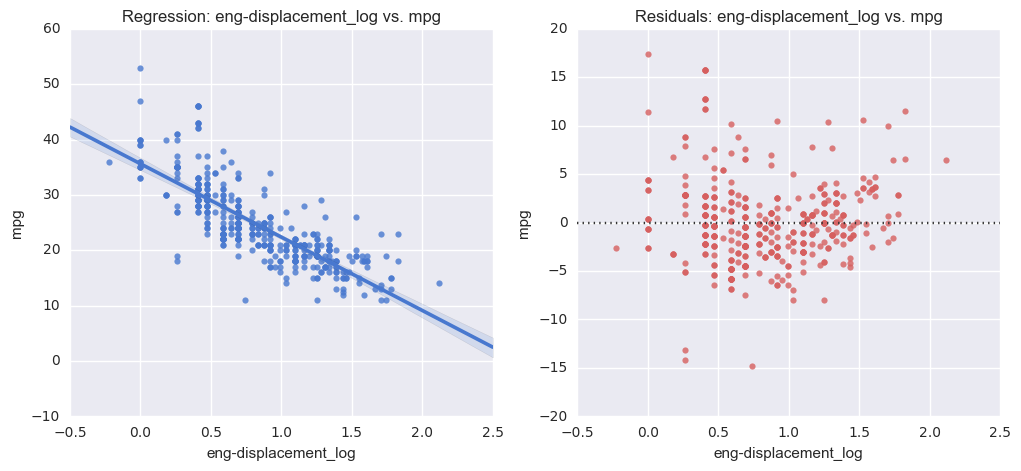

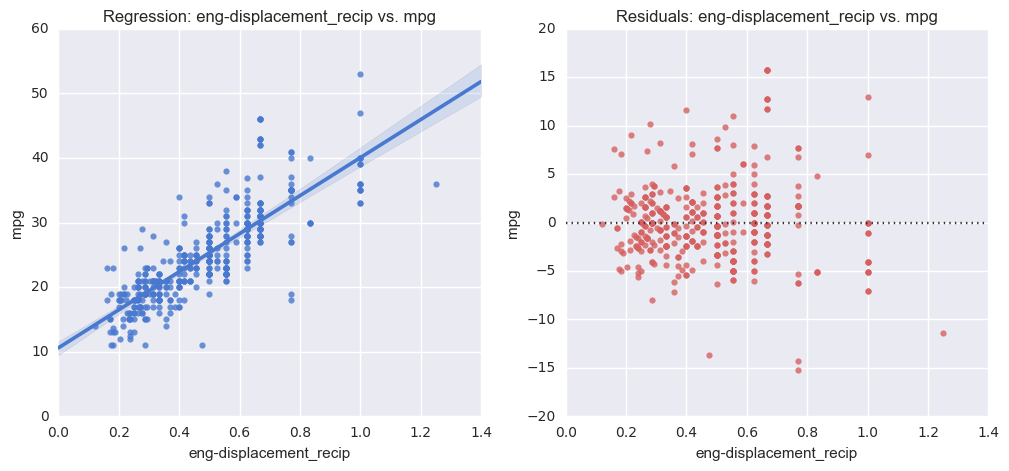

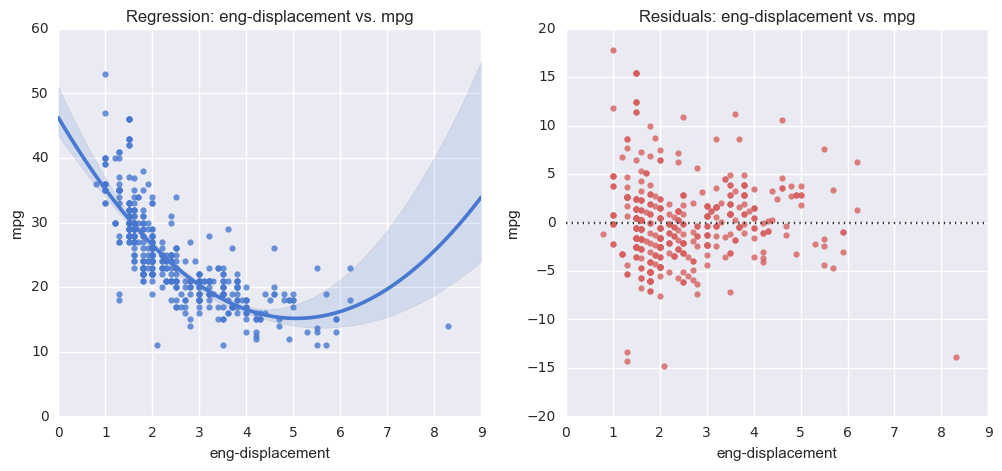

In [438]:
df['eng-displacement_log'] = [x for x in map(lambda x: math.log(x), df['eng-displacement'])]
plot_regression('eng-displacement_log')

df['eng-displacement_recip'] = [x for x in map(lambda x: 1/x, df['eng-displacement'])]
plot_regression('eng-displacement_recip')

plot_regression('eng-displacement', order=2)

## Transforming `cylinders`

Used a reciprocal transformation.

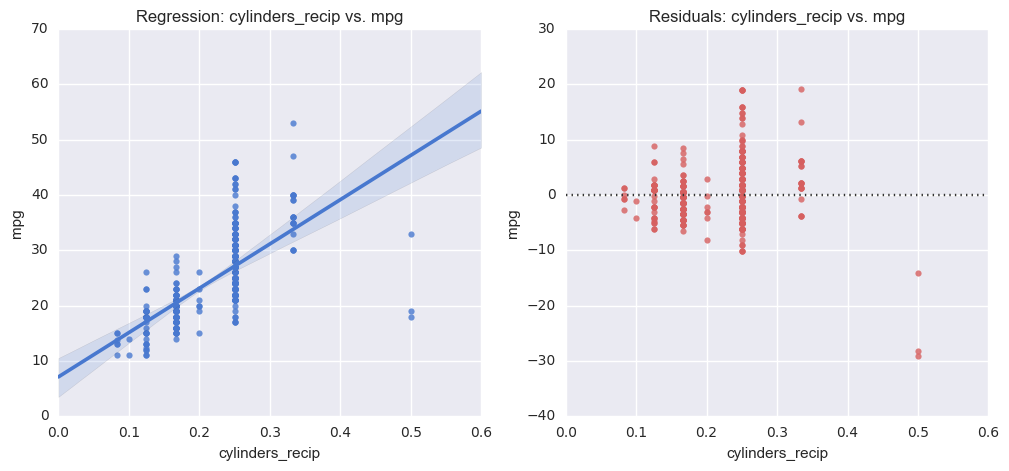

In [417]:
df['cylinders_recip'] = [x for x in map(lambda c: 1/c, df['cylinders'])]
plot_regression('cylinders_recip')

## Transforming `height`

Noticing the original graph appears linearly separable, we divide $h$ into two regions: between 52 and 62 exclusive, and outside.

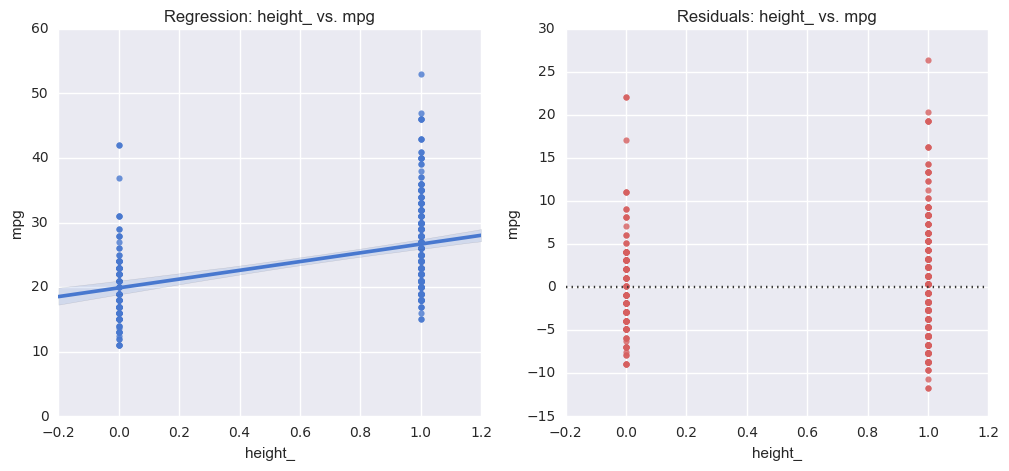

In [430]:
df['height_'] = [x for x in map(lambda h: 1 if h > 52 and h < 62 else 0, df['height'])]
plot_regression('height_')

# Final model: $r^2 = 0.711$

Predictors:

- `52 < height < 60`,
- `1 / cylinders`,
- `1 / eng-displacement`
- `percent-weight-front` (unmodified)

In [439]:
regress([
    'height_',
    'cylinders_recip',
    'eng-displacement_recip',
    'percent-weight-front',
])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     257.7
Date:                Mon, 20 Nov 2017   Prob (F-statistic):          1.69e-111
Time:                        02:21:58   Log-Likelihood:                -1169.1
No. Observations:                 424   AIC:                             2348.
Df Residuals:                     419   BIC:                             2368.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                      3.0708      1.935      1.587      0.113        -0.733     6.875
height_                    1.9021      0.479      3.970      0.000         0.960     2.844
cylinders_recip          -17.7583      6.151     -2.887      0.004       -29.849    -5.667
eng-displacement_recip    31.7893      1.877     16.934      0.000        28.099    35.479
percent-weight-front       0.1556      0.034      4.515      0.000         0.088     0.223
==============================================================================
Omnibus:                       95.273   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.906
Skew:                           1.085   Prob(JB):                     3.28e-55
Kurtosis:                       6.081   Cond. No.                     1.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Random experiments: IGNORE for video

## First attempt at regression: $r^2 = 0.561$

Using variables that look reasonably linearly correlated in the above plots: `weight`, `width`, and `cylinders`.

In [433]:
regress([
    'weight',
    'width', 
    'cylinders',
])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     179.0
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           9.68e-75
Time:                        02:20:00   Log-Likelihood:                -1257.7
No. Observations:                 424   AIC:                             2523.
Df Residuals:                     420   BIC:                             2540.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         50.7929      6.361      7.985      0.000        38.290    63.296
weight        -0.0044      0.001     -7.256      0.000        -0.006    -0.003
width         -0.0834      0.113     -0.738      0.461        -0.305     0.139
cylinders     -1.4842      0.193     -7.687      0.000        -1.864    -1.105
==============================================================================
Omnibus:                      113.104   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.235
Skew:                           1.250   Prob(JB):                     8.75e-72
Kurtosis:                       6.504   Cond. No.                     8.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## With `weight` and `eng-displacement_recip`: $r^2 = 0.667$

In [414]:
df['eng-displacement_sq'] = [x for x in map(lambda x: x**2, df['eng-displacement'])]

regress([
    'weight',
    'eng-displacement_recip',
#     'eng-displacement_sq',
#     'eng-displacement', 
])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     420.8
Date:                Mon, 20 Nov 2017   Prob (F-statistic):          3.88e-101
Time:                        02:10:55   Log-Likelihood:                -1199.4
No. Observations:                 424   AIC:                             2405.
Df Residuals:                     421   BIC:                             2417.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                     13.5400      2.303      5.879      0.000         9.013    18.067
weight                    -0.0007      0.001     -1.310      0.191        -0.002     0.000
eng-displacement_recip    27.4400      1.843     14.886      0.000        23.817    31.063
==============================================================================
Omnibus:                       76.474   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.890
Skew:                           0.849   Prob(JB):                     8.00e-48
Kurtosis:                       6.065   Cond. No.                     4.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fixing `percent-weight-front`

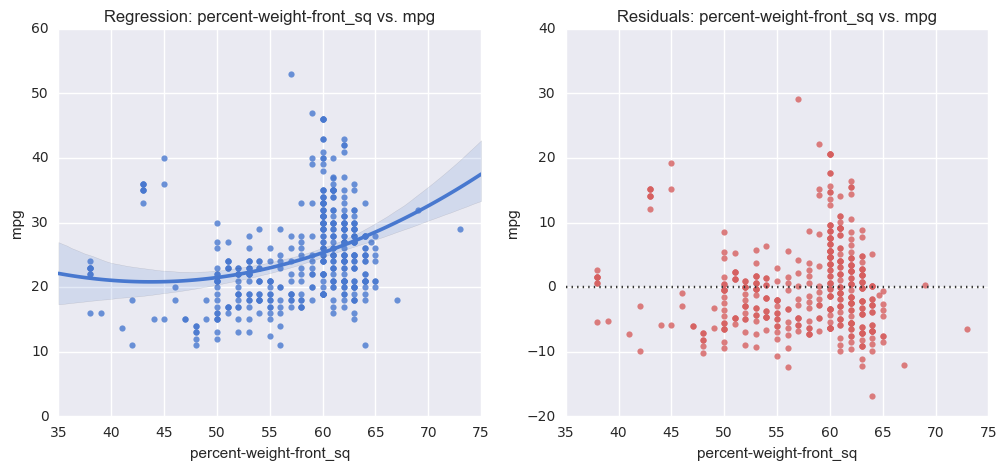

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     164.3
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           1.86e-70
Time:                        01:39:30   Log-Likelihood:                -1267.7
No. Observations:                 424   AIC:                             2543.
Df Residuals:                     420   BIC:                             2560.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                      -0.0161      0.008     -2.132      0.034        -0.031    -0.001
weight                     -0.0065      0.000    -17.679      0.000        -0.007    -0.006
height_                     2.7121      0.595      4.560      0.000         1.543     3.881
eng-displacement_recip      0.0974      0.017      5.815      0.000         0.064     0.130
percent-weight-front_    -4.76e-14   3.77e-15    -12.618      0.000      -5.5e-14 -4.02e-14
percent-weight-front_sq     0.8499      0.028     30.156      0.000         0.795     0.905
==============================================================================
Omnibus:                      108.663   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.570
Skew:                           1.258   Prob(JB):                     3.94e-60
Kurtosis:                       6.026   Cond. No.                     3.83e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [338]:
df['percent-weight-front_sq'] = [x for x in map(lambda x: x, df['percent-weight-front'])]
plot_regression('percent-weight-front_sq', order=2)

regress([
    'weight',
    'height_',
    'eng-displacement_recip',
    'percent-weight-front_',
    'percent-weight-front_sq',
])

### Regression w scikit-learn

In [424]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)
# X_ = poly.fit_transform(X)

clf = linear_model.LinearRegression()
clf.fit(X, y)
clf.score(X, y)

0.66658418867442271